# Analyzing duplicates in Tufano data and removing them from commit message dataset

In [42]:
from pathlib import Path
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [113]:
def duplicates_in_collected_dataset():
    root = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Tufano/'
    folders = ['test', 'train', 'val']
    remove_counter = {'test': 0, 'train': 0, 'val': 0}
    sizes = {}
    for folder in folders:
        prevs = Path(root + folder + '/prev.txt').read_text().splitlines()
        updateds = Path(root + folder + '/updated.txt').read_text().splitlines()
        msgs = Path(root + folder + '/msg.txt').read_text().splitlines()
        sizes[folder] = len(prevs)
        prevs_set, updateds_set, msgs_set = set(), set(), set()
        counter = defaultdict(lambda: 1)
        for prev, updated, msg in zip(prevs, updateds, msgs):
            if prev in prevs_set and updated in updateds_set and msg in msgs_set:
                counter[(prev, updated, msg)] += 1
                remove_counter[folder] += 1
                print((prev, updated, msg))
            elif prev not in prevs_set and updated not in updateds_set and msg not in msgs_set:
                prevs_set.add(prev)
                updateds_set.add(updated)
                msgs_set.add(msg)
                #if prev == 'TYPE_1 METHOD_1 ( ) ;':
                #    print(prev)
                #    print(updated)
                #    print(msg)
            else:
                #print(f'prev: {prev in prevs_set}')
                #print(f'updated: {updated in updateds_set}')
                #print(f'msg: {msg in msgs_set}')
                #print()
                #print(f'prev now: {prev}')
                #print(f'updated now: {updated}')
                #print(f'msg now: {msg}')
                a = 0
        #print(len(counter))
        a = 0
    print(f'{remove_counter}')
    print(f'{sizes}')

In [114]:
duplicates_in_collected_dataset()

('java.lang.String METHOD_1 ( ) ;', 'java.lang.String METHOD_1 ( ) ;', 'Fix typo')
('protected void METHOD_1 ( TYPE_1 event ) { super . METHOD_1 ( event ) ; if ( ( ( VAR_1 ) != null ) && ( ( event . METHOD_2 ( ) ) == ( VAR_2 ) ) ) { VAR_1 . METHOD_3 ( event . METHOD_4 ( ) ) ; } }', 'protected void METHOD_1 ( TYPE_1 event ) { super . METHOD_1 ( event ) ; if ( ( ( VAR_1 ) != null ) && ( ( event . METHOD_2 ( ) ) == ( VAR_3 ) ) ) { VAR_1 . METHOD_3 ( event . METHOD_4 ( ) ) ; } }', 'DialogBoxWithKeyHandlers - remove ONKEYPRESS event')
{'test': 0, 'train': 2, 'val': 0}
{'test': 648, 'train': 4694, 'val': 543}


In [115]:
def draw_length_dist():
    root = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Tufano/'
    folders = ['test', 'train', 'val']
    lengths = {'prev': [], 'updated': [], 'msg': []}
    for folder in folders:
        prevs = Path(root + folder + '/prev.txt').read_text().splitlines()
        updateds = Path(root + folder + '/updated.txt').read_text().splitlines()
        msgs = Path(root + folder + '/msg.txt').read_text().splitlines()
        for i, (prev, updated, msg) in enumerate(zip(prevs, updateds, msgs)):
            prev_tokens = prev.split()
            updated_tokens = updated.split()
            msg_tokens = msg.split()
            lengths['prev'].append(len(prev_tokens))
            lengths['updated'].append(len(updated_tokens))
            lengths['msg'].append(len(msg_tokens))
            #if len(prev_tokens) == 7 or len(updated_tokens) == 7:
            #    print(f'prev: {prev}')
            #    print(f'updated: {updated}')
            #    print(f'msg: {msg}')
            #    print()
            #if len(msg_tokens) <= 1:
            #    print(msg_tokens)
    f, axes = plt.subplots(len(lengths), 1, figsize=(20, 20))
    for i, k in enumerate(lengths.keys()):
        #print(f'Min: {min(lengths[k])}')
        sns.distplot(np.array(lengths[k]), ax=axes[i], axlabel=k)
    plt.show()

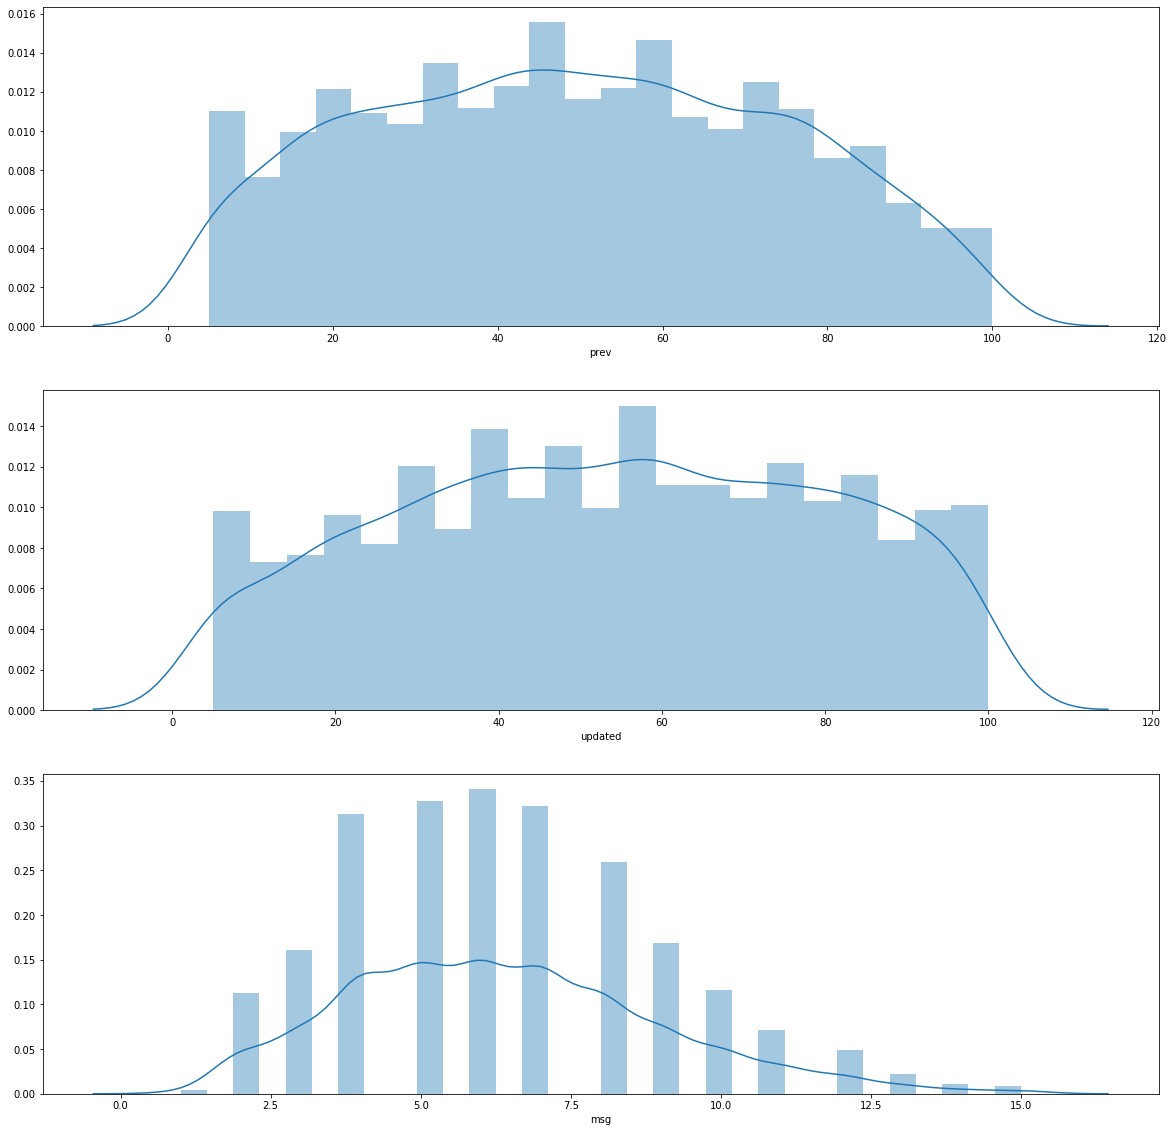

In [116]:
draw_length_dist()

In [164]:
def remove_lines_from_file(line_nums, filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
    with open(filepath, "w") as f:
        for line, should_be_removed in zip(lines, line_nums):
            if not should_be_removed:
                f.write(line)

def remove_lines(line_nums, root, filenames):
    for filename in filenames:
        remove_lines_from_file(line_nums, root + filename)

In [165]:
def get_lines_on_predicate(pred):
    root = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Tufano/'
    folders = ['test', 'train', 'val']
    line_ids = {'test': [], 'train': [], 'val': []}
    for folder in folders:
        prevs = Path(root + folder + '/prev.txt').read_text().splitlines()
        updateds = Path(root + folder + '/updated.txt').read_text().splitlines()
        msgs = Path(root + folder + '/msg.txt').read_text().splitlines()
        for i, data in enumerate(zip(prevs, updateds, msgs)):
            line_ids[folder].append(pred(data))
    return {k: np.array(v) for k, v in line_ids.items()}

In [166]:
def filter_on_predicate_show_stats(pred):
    lines = get_lines_on_predicate(pred)
    total_to_filter, total = 0, 0
    for key in lines:
        print(f'{key}: {lines[key].sum()} / {len(lines[key])} = {lines[key].sum() / len(lines[key])}')
        total_to_filter += lines[key].sum()
        total += len(lines[key])
    print(f'Total: {total_to_filter} / {total} = {total_to_filter / total}')
    print(f'Will be left: {total - total_to_filter}')

In [167]:
def filter_on_predicate(pred):
    root = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Tufano/'
    lines = get_lines_on_predicate(pred)
    files = ['diff.txt', 'msg.txt', 'prev.txt', 'updated.txt']
    for key, value in lines.items():
        remove_lines(value, root + key + '/', files)

In [168]:
def get_complete_duplicates_predicate():
    seen = set()
    def pred(data):
        if data in seen:
            return True
        else:
            seen.add(data)
            return False
    return pred

In [169]:
filter_on_predicate_show_stats(get_complete_duplicates_predicate())

test: 6 / 654 = 0.009174311926605505
train: 538 / 5232 = 0.10282874617737003
val: 111 / 654 = 0.16972477064220184
Total: 655 / 6540 = 0.10015290519877676
Will be left: 5885


In [170]:
filter_on_predicate(get_complete_duplicates_predicate())

In [171]:
filter_on_predicate_show_stats(get_complete_duplicates_predicate())

test: 0 / 648 = 0.0
train: 0 / 4694 = 0.0
val: 0 / 543 = 0.0
Total: 0 / 5885 = 0.0
Will be left: 5885


In [172]:
def get_prev_equals_updated_predicate(verbose=False):
    def pred(data):
        prev, updated, msg = data
        if verbose and prev == updated:
            print(prev)
            print(updated)
            print(msg)
            print()
        return prev == updated
    return pred

In [173]:
filter_on_predicate_show_stats(get_prev_equals_updated_predicate(verbose=True))

public void METHOD_1 ( TYPE_1 state ) { TYPE_2 VAR_1 = ( ( TYPE_2 ) ( state ) ) ; super . METHOD_1 ( VAR_1 . METHOD_2 ( ) ) ; METHOD_3 ( VAR_2 ) ; METHOD_4 ( ) ; }
public void METHOD_1 ( TYPE_1 state ) { TYPE_2 VAR_1 = ( ( TYPE_2 ) ( state ) ) ; super . METHOD_1 ( VAR_1 . METHOD_2 ( ) ) ; METHOD_3 ( VAR_2 ) ; METHOD_4 ( ) ; }
Add ripple effect to RTT incall buttons

public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( this . VAR_1 ) ; }
public void METHOD_1 ( ) { TYPE_1 . METHOD_2 ( this . VAR_1 ) ; }
adding IsolateVolumeVDSCommand

public java.util.List < TYPE_1 > list ( ) throws java.io.IOException , TYPE_2 , TYPE_3 { java.lang.String url = ( ( this . VAR_1 . METHOD_1 ( ) ) + ( VAR_2 ) ) + ( getName ( ) ) ; return list ( url , VAR_3 class , VAR_4 class ) ; }
public java.util.List < TYPE_1 > list ( ) throws java.io.IOException , TYPE_2 , TYPE_3 { java.lang.String url = ( ( this . VAR_1 . METHOD_1 ( ) ) + ( VAR_2 ) ) + ( getName ( ) ) ; return list ( url , VAR_3 class , VAR_4 class ) ; }
Reg

In [174]:
filter_on_predicate(get_prev_equals_updated_predicate())

In [175]:
filter_on_predicate_show_stats(get_prev_equals_updated_predicate(verbose=True))

test: 0 / 599 = 0.0
train: 0 / 4319 = 0.0
val: 0 / 494 = 0.0
Total: 0 / 5412 = 0.0
Will be left: 5412


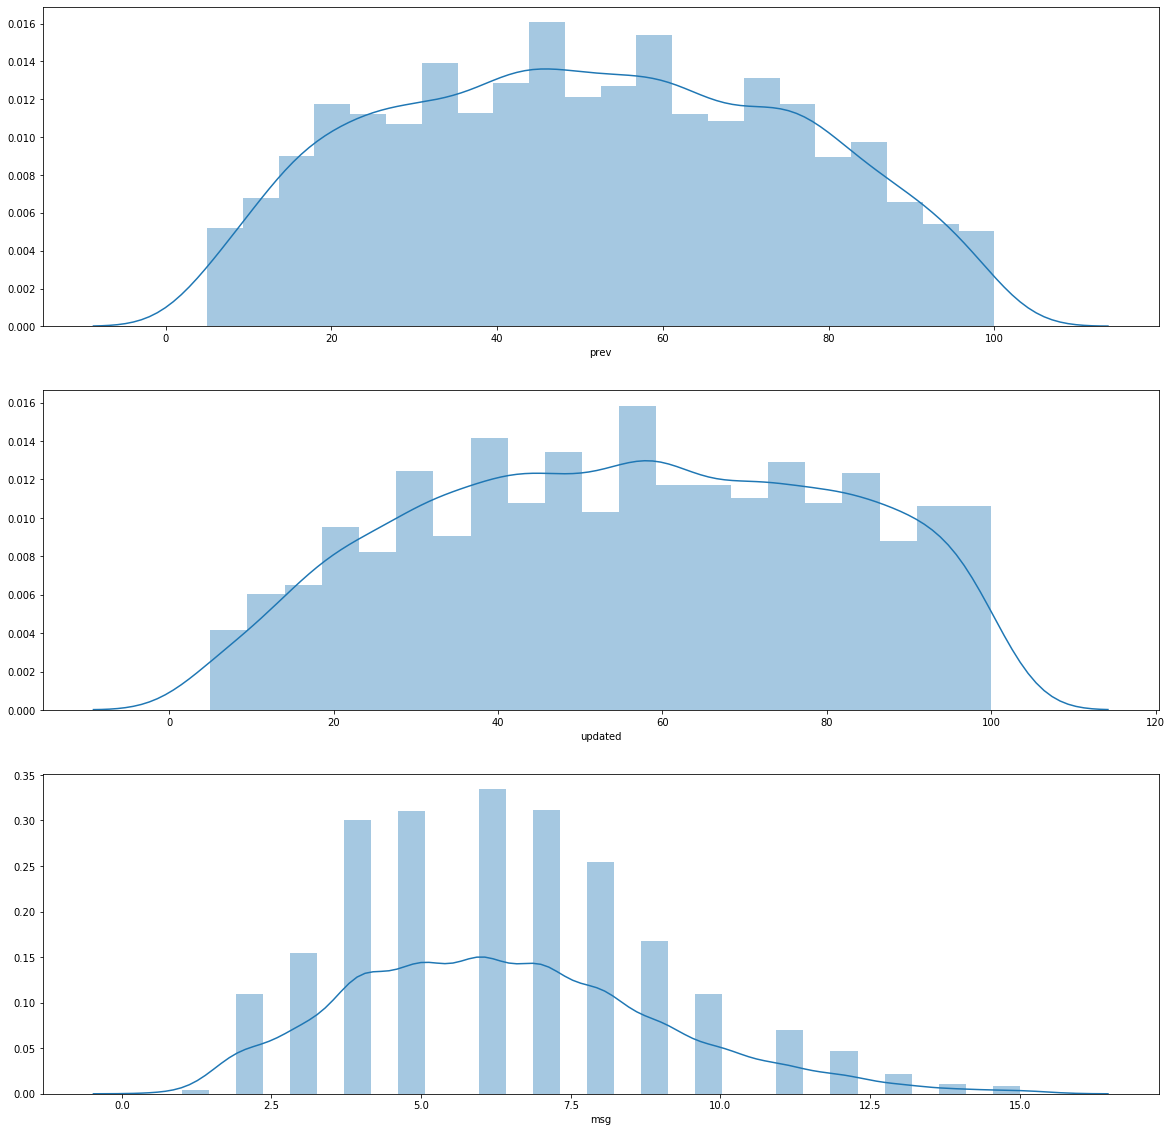

In [176]:
draw_length_dist()

In [183]:
def get_no_body_predicate(verbose=False):
    def pred(data):
        prev, updated, msg = data
        is_true = len(prev.split()) == 5 and len(updated.split()) == 5
        #is_true = prev.endswith('( ) ;')
        if verbose and is_true:
            print(prev)
            print(updated)
            print(msg)
            print()
        return is_true
    return pred

In [184]:
filter_on_predicate_show_stats(get_no_body_predicate(verbose=True))

TYPE_1 METHOD_1 ( ) ;
TYPE_1 METHOD_2 ( ) ;
Minor update to the layoutlib API

TYPE_1 METHOD_1 ( ) ;
TYPE_1 METHOD_2 ( ) ;
Replace generic `` Status '' type with specific ones

java.lang.String METHOD_1 ( ) ;
java.lang.String METHOD_2 ( ) ;
passthrough and port mirroring must always be disabled for external networks

TYPE_1 METHOD_1 ( ) ;
TYPE_1 METHOD_2 ( ) ;
Fix typo in the name of the OpenStack image providers locator

java.lang.String METHOD_1 ( ) ;
java.lang.String METHOD_2 ( ) ;
Add VM lease storage domain status validation before running a VM

java.lang.String METHOD_1 ( ) ;
java.lang.String METHOD_2 ( ) ;
move disks popup - fix alignment

java.lang.String METHOD_1 ( ) ;
java.lang.String METHOD_2 ( ) ;
Remove OVF store checks in DiskValidator

java.lang.String METHOD_1 ( ) ;
java.lang.String METHOD_2 ( ) ;
improve host kernel configuration message

java.lang.String METHOD_1 ( ) ;
java.lang.String METHOD_2 ( ) ;
Correct enum translator value for NFS V4.1

java.lang.String METHOD_

In [185]:
filter_on_predicate(get_no_body_predicate())

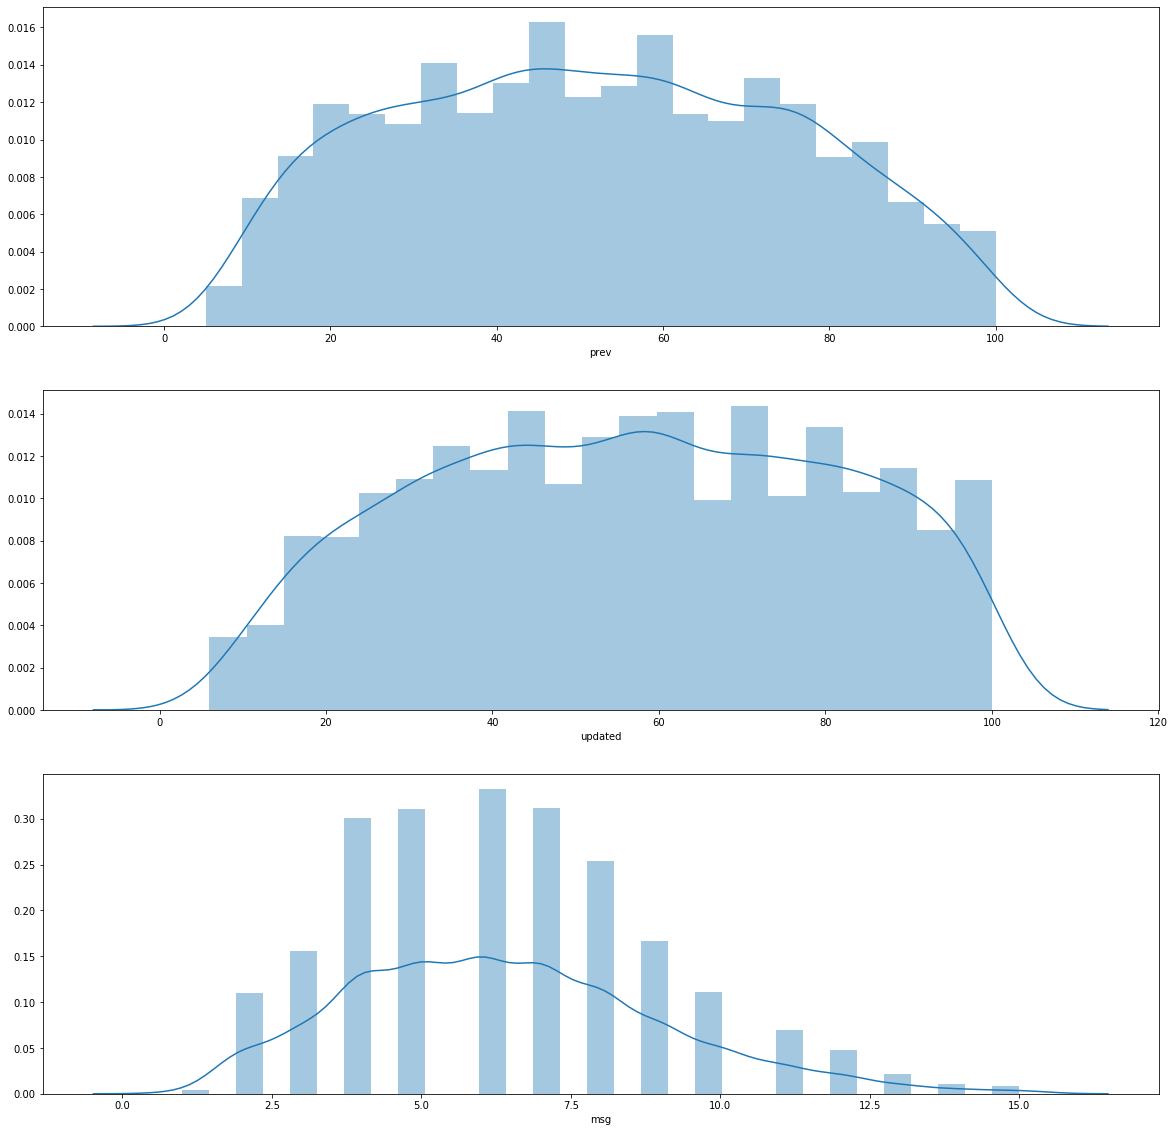

In [186]:
draw_length_dist()

In [187]:
filter_on_predicate_show_stats(get_no_body_predicate(verbose=True))

test: 0 / 587 = 0.0
train: 0 / 4266 = 0.0
val: 0 / 488 = 0.0
Total: 0 / 5341 = 0.0
Will be left: 5341


In [108]:
def filter_methods_without_body():
    root = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Tufano/'
    folders = ['test', 'train', 'val']
    line_ids = {'test': [], 'train': [], 'val': []}
    without_body_tokens = ['(', ')', ';']
    for folder in folders:
        prevs = Path(root + folder + '/prev.txt').read_text().splitlines()
        updateds = Path(root + folder + '/updated.txt').read_text().splitlines()
        msgs = Path(root + folder + '/msg.txt').read_text().splitlines()
        for i, (prev, updated, msg) in enumerate(zip(prevs, updateds, msgs)):
            prev_tokens = prev.split()
            updated_tokens = updated.split()
            if prev[-3:] == without_body_tokens and updated[-3:]

SyntaxError: invalid syntax (<ipython-input-108-5d516891ef93>, line 13)